### Introduction

In this project, we  will create and train multi-task, multi-output models with Keras. we will use Keras' functional API to create a multi output model which will be trained to learn two different labels given the same input example. The model will have one input but two outputs. A few of the shallow layers will be shared between the two outputs, we will also use a ResNet style skip connection in the model. 

### Setting Envirement

In [2]:
#import libraires
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
import shutil

try:
  shutil.rmtree('logs')
except:
  pass

### Create Dataset

In [3]:
#use keras dataset to download mnist dataset
(x_train,y_train),(x_test,y_test)=tf.keras.datasets.mnist.load_data()

11490434/11490434 [==============================] - 16s 1us/step


In [4]:
def create_example(x,y):
    c=np.random.randint(0,2)
    image=0.5 * np.random.rand(28,28,3)
    image[:,:,c]+= 0.5 * x / 255.  
    return image ,y ,c 


digit:5 , color : red


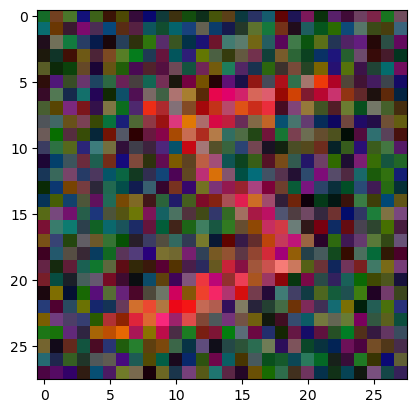

In [6]:
colors={0:'red',1:'green'}
x,y,c=create_example(x_train[0] , y_train[0])
print(f'digit:{y} , color : {colors[c]}')
plt.imshow(x)
plt.show()

### Generating Dataset

In [12]:
 def generate_data(x,y,batch_size=32):
     num_examples = len(y)
     while True :
         x_batch = np.zeros((batch_size,28,28,3))
         y_batch= np.zeros(batch_size)
         c_batch= np.zeros(batch_size)
         for i in range(0,batch_size) :
             index=np.random.randint(0,num_examples)
             image , digit , color = create_example(x[index],y[index])
             x_batch[i] = image 
             y_batch[i]=digit
             c_batch[i] = color
         yield x_batch,[y_batch,c_batch]
     

In [13]:
x,[y,c] = next(generate_data(x_test,y_test,batch_size=1))

[8.] [0.]


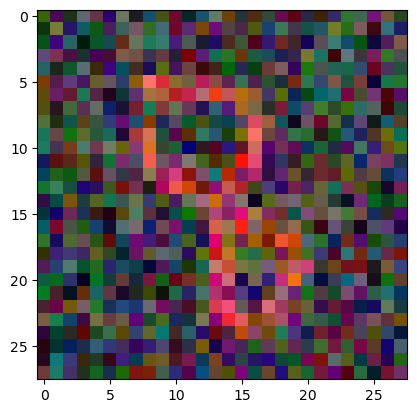

In [14]:
print(y,c)
plt.imshow(x[0]);

### Model Architecture

In [15]:
from tensorflow.keras.layers import Input,Conv2D,Activation,MaxPool2D,Flatten,Add,Dense

In [18]:
input_ = Input(shape=(28,28,3),name='input')
#First output
conv_1=Conv2D(32,3,name='conv_1')(input_)
act_1=Activation('relu',name='act_1')(conv_1)
pool_1=MaxPool2D(4,name='pool_1')(act_1)
flat_1=Flatten(name='flat_1')(pool_1)
color=Dense(1,activation='sigmoid',name='color')(flat_1)
#Second output
conv_2 = Conv2D(32,3,padding="same",name="conv_2")(act_1)
act_2=Activation('relu',name='act_2')(conv_2)
conv_3 = Conv2D(32,3,padding="same",name="conv_3")(act_2)
#skip connection
add=Add(name="add")([act_1,conv_3])
act_3=Activation('relu',name='act_3')(add)
pool_2=MaxPool2D(4,name="pool_2")(act_3)
flat_2=Flatten(name='flat_2')(pool_2)
digit=Dense(10,activation="softmax",name="digit")(flat_2) 
model=tf.keras.models.Model(input_,[digit,color])
model.compile(
    loss={
        'digit':'sparse_categorical_crossentropy',
        'color':'binary_crossentropy'
    },
    optimizer='adam',
    metrics=['accuracy']
    
)
model.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input (InputLayer)          [(None, 28, 28, 3)]          0         []                            
                                                                                                  
 conv_1 (Conv2D)             (None, 26, 26, 32)           896       ['input[0][0]']               
                                                                                                  
 act_1 (Activation)          (None, 26, 26, 32)           0         ['conv_1[0][0]']              
                                                                                                  
 conv_2 (Conv2D)             (None, 26, 26, 32)           9248      ['act_1[0][0]']               
                                                                                              

In [24]:
tf.keras.utils.plot_model(model)

You must install pydot (`pip install pydot`) and install graphviz (see instructions at https://graphviz.gitlab.io/download/) for plot_model to work.


### Model Training

In [25]:
class Logger(tf.keras.callbacks.Callback):
  def on_epoch_end(self, epoch, logs=None):
    digit_accuracy = logs.get('digit_accuracy')
    color_accuracy = logs.get('color_accuracy')
    val_digit_accuracy = logs.get('val_digit_accuracy')
    val_color_accuracy = logs.get('val_color_accuracy')
    print('='*30, epoch + 1, '='*30)
    print(f'digit_accuracy: {digit_accuracy:.2f}, color_accuracy: {color_accuracy:.2f}')
    print(f'val_digit_accuracy: {val_digit_accuracy:.2f}, val_color_accuracy: {val_color_accuracy:.2f}')

In [27]:
train_gen=generate_data(x_train,y_train)
test_gen=generate_data(x_test,y_test)
_=model.fit(
    train_gen,
    validation_data=test_gen,
    steps_per_epoch=200,
    validation_steps=100,
    epochs=10,
    callbacks=[
        Logger(),
        tf.keras.callbacks.TensorBoard(log_dir='./logs'),
    ],
    verbose=False
)

============================== 1 ==============================
digit_accuracy: 0.55, color_accuracy: 0.96
val_digit_accuracy: 0.86, val_color_accuracy: 1.00
============================== 2 ==============================
digit_accuracy: 0.89, color_accuracy: 1.00
val_digit_accuracy: 0.90, val_color_accuracy: 1.00
============================== 3 ==============================
digit_accuracy: 0.93, color_accuracy: 1.00
val_digit_accuracy: 0.95, val_color_accuracy: 1.00
============================== 4 ==============================
digit_accuracy: 0.94, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 5 ==============================
digit_accuracy: 0.95, color_accuracy: 1.00
val_digit_accuracy: 0.96, val_color_accuracy: 1.00
============================== 6 ==============================
digit_accuracy: 0.96, color_accuracy: 1.00
val_digit_accuracy: 0.97, val_color_accuracy: 1.00
============================== 7 ===================

In [29]:
!tensorboard --logdir logs

^C



### Model Prediction

In [30]:
def test_model(show=True):
  x, [y, c] = next(test)
  
  preds = model.predict(x)
  pred_digit = np.argmax(preds[0])
  pred_color = int(preds[1] > 0.5)
  gt_digit = int(y[0])
  gt_color = int(c[0])
  
  plt.imshow(x[0])
  if show:
    print(f'GT: {gt_digit}, {colors[gt_color]}')
    print(f'Pr: {pred_digit}, {colors[pred_color]}')
    plt.show()
  else:
    col = 'green' if gt_digit == pred_digit and gt_color == pred_color else 'red'
    plt.ylabel(f'GT: {gt_digit}, {colors[gt_color]}', color=col)
    plt.xlabel(f'Pr: {pred_digit}, {colors[pred_color]}', color=col)
    plt.xticks([])
    plt.yticks([])


test = generate_data(x_test, y_test, batch_size=1)

1/1 [==============================] - 0s 35ms/step
GT: 1, green
Pr: 1, green


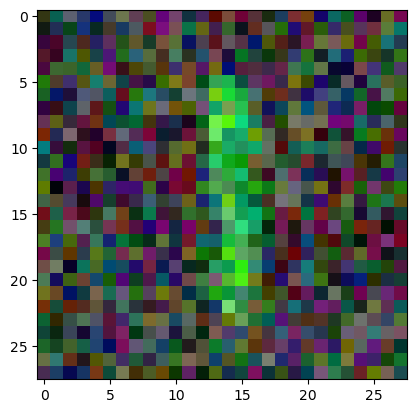

In [35]:
test_model()

1/1 [==============================] - 0s 47ms/step


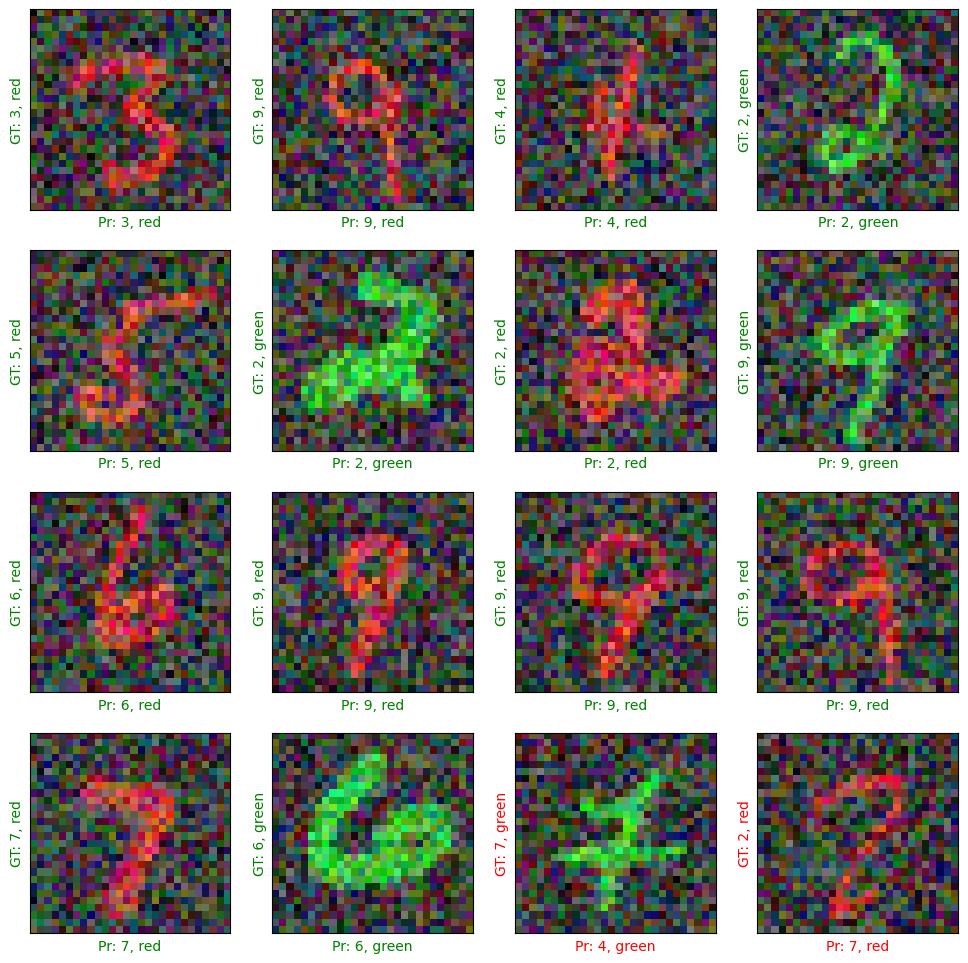

In [36]:
plt.figure(figsize=(12,12))
for i in range(0,16):
    plt.subplot(4,4,i+1)
    test_model(show=False)
plt.savefig("prediction.png")
plt.show()

In [37]:
model.save('models/mymodel')

INFO:tensorflow:Assets written to: models/mymodel\assets


INFO:tensorflow:Assets written to: models/mymodel\assets
